# Total days of smoke PM vs total PM

In [4]:
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
pm25 = xr.open_dataset("data/wc/PM25_daily_CensusTract_2005_2020_WesternUS.nc")

In [3]:
pm25

<xarray.Dataset>
Dimensions:                                   (time: 5827, locations: 18010,
                                               labelDim: 18010)
Coordinates:
  * time                                      (time) datetime64[ns] 2005-01-0...
    lat                                       (locations) float64 ...
    lon                                       (locations) float64 ...
Dimensions without coordinates: locations, labelDim
Data variables: (12/14)
    projection                                int32 ...
    x                                         (locations) float64 ...
    y                                         (locations) float64 ...
    poly_breaks                               (locations) int32 ...
    poly_coords                               (locations) float64 ...
    time_step_ID                              (time, locations) float64 ...
    ...                                        ...
    FIPS                                      (time, locations) float64 ...
    PREDICTION_BINARY_MASK                    (time, locations) int32 ...
    MEAN_NONE_SPATIAL_NEIGHBORS               (time, locations) float64 ...
    MEAN_NONE_SPATIAL_NEIGHBORS_TREND_ZSCORE  (locations) float64 ...
    MEAN_NONE_SPATIAL_NEIGHBORS_TREND_PVALUE  (locations) float64 ...
    MEAN_NONE_SPATIAL_NEIGHBORS_TREND_BIN     (locations) float64 ...
Attributes: (12/27)
    agg_shape_type:             Polygon
    geometry_unit:              METER
    convert_factor:             1.0
    alignment:                  START_TIME
    reference_time:             
    time_size:                  1
    ...                         ...
    extent:                     [-2356112.7933  -614977.1693  -504620.7696  1...
    esri_pe_string:             PROJCS["USA_Contiguous_Albers_Equal_Area_Coni...
    projection_authority_code:  102003
    raw_pe_string:              PROJCS["USA_Contiguous_Albers_Equal_Area_Coni...
    location_id_field:          FIPS
    rate_info:

In [4]:
df_pm25 = pm25[["MEAN_NONE_SPATIAL_NEIGHBORS"]].to_dataframe()
df_pm25 = df_pm25.rename(columns={"MEAN_NONE_SPATIAL_NEIGHBORS": "pm25"})
df_pm25 = df_pm25.reset_index()

In [5]:
df_pm25 = df_pm25[["time", "locations", "pm25"]]
df_pm25.head()

,time,locations,pm25
0,2005-01-01,0,2.406896
1,2005-01-01,1,1.727934
2,2005-01-01,2,1.745349
3,2005-01-01,3,1.673608
4,2005-01-01,4,2.578539


## Time preselection

In [6]:
df_pm25['time'] = pd.to_datetime(df_pm25['time'])
df_pm25 = df_pm25[df_pm25['time'] >= '2006-01-01']
df_pm25 = df_pm25[df_pm25['time'] <= '2020-12-31']

## Get location ID

In [7]:
locs = pm25[["location_label"]].to_dataframe()

In [8]:
len(df_pm25)

98370620

In [9]:
df = df_pm25.merge(locs, left_on='locations', right_on="labelDim", how='left')

In [10]:
len(df)

98370620

## Get metrics

In [11]:
df = df[["time","location_label","pm25"]]
df = df.groupby(by=["time","location_label"]).first().reset_index()
df.head()

,time,location_label,pm25
0,2006-01-01,04001942600,1.584188
1,2006-01-01,04001942700,0.995125
2,2006-01-01,04001944000,1.071151
3,2006-01-01,04001944100,0.938343
4,2006-01-01,04001944201,1.541156


In [12]:
df['polluted_over_zero'] = np.where(df['pm25'] > 0.0, True, False)
df['polluted_over_five'] = np.where(df['pm25'] > 5.0, True, False)
df['polluted_over_35'] = np.where(df['pm25'] >= 35, True, False)

In [14]:
data.time.min()

Timestamp('2006-01-01 00:00:00')

In [15]:
data.time.max()

Timestamp('2020-12-14 00:00:00')

In [ ]:
df.to_parquet("outputs/total_total_pm25_pollution.parquet")

## Plots

In [6]:
df = pd.read_parquet("outputs/total_total_pm25_pollution.parquet")

In [9]:
grouped = df.groupby("location_label")[["polluted_over_zero","polluted_over_five","polluted_over_35"]].sum()

In [11]:
df = grouped.reset_index()

In [12]:
gdf = gpd.read_file('data/WesternUSCensusTract/CensusTract2020_WesternUS.shp')
data = gdf.merge(df, left_on="FIPS", right_on="location_label")

In [3]:
from textwrap3 import wrap

In [13]:
titles = {
    'polluted_over_zero': "non zero",
    'polluted_over_five': "over 5ug/m^3",
    'polluted_over_35': "over 35um/m^3"
}

In [18]:
import helper_400
helper_400.set_sns_style()

<Figure size 800x600 with 0 Axes>

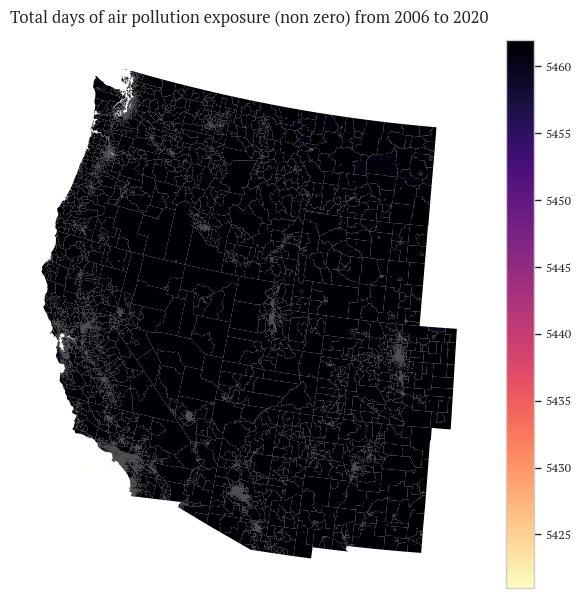

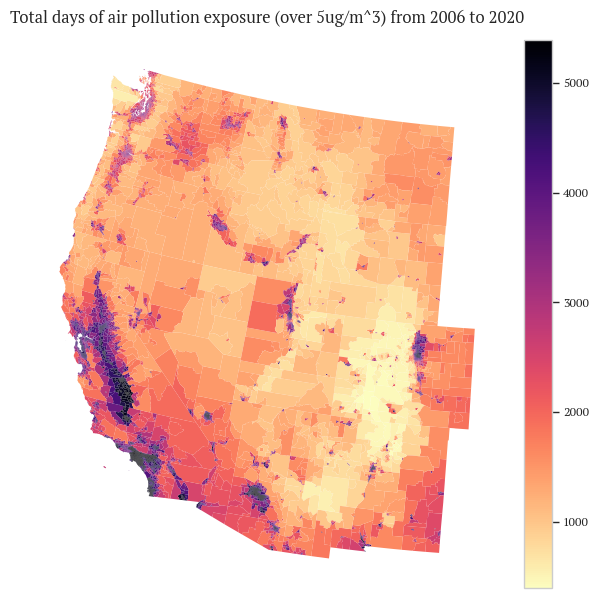

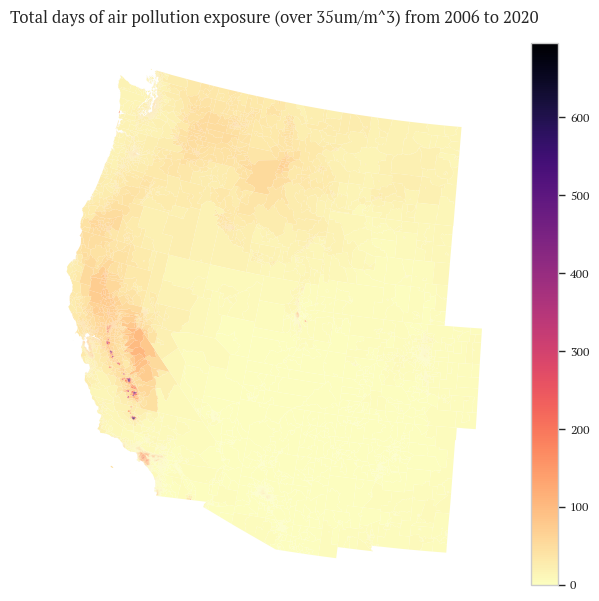

In [19]:
for x in titles.keys():
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    data.plot(
        column=x, ax=ax, legend=True, linewidth=0, cmap="magma_r", missing_kwds={"color": "lightgrey"},
        )

    title_text = "Total days of air pollution exposure ("+ titles[x]+ ") from 2006 to 2020"
    wrapped_title = wrap(title_text, 50)
    ax.set_title(title_text, fontsize=12)
    ax.set_axis_off()

    plt.tight_layout()
    plt.savefig("figures/centract_hotspots_wc_total_pm25_air"+x+".png")
    plt.show()